In [17]:
import sys, getopt

import argparse

import sys
import os
import time

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot  as pyplot
import gzip

import theano
import theano.tensor as T

import lasagne
import nolearn

In [16]:
def load_dataset_mnist():
	# We first define a download function, supporting both Python 2 and 3.
	if sys.version_info[0] == 2:
		from urllib import urlretrieve
	else:
		from urllib.request import urlretrieve

	def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
		print("Downloading %s" % filename)
		urlretrieve(source + filename, filename)

	# We then define functions for loading MNIST images and labels.
	# For convenience, they also download the requested files if needed.
	import gzip

	def load_mnist_images(filename):
		if not os.path.exists(filename):
			download(filename)
		# Read the inputs in Yann LeCun's binary format.
		with gzip.open(filename, 'rb') as f:
			data = np.frombuffer(f.read(), np.uint8, offset=16)
		# The inputs are vectors now, we reshape them to monochrome 2D images,
		# following the shape convention: (examples, channels, rows, columns)
		data = data.reshape(-1, 1, 28, 28)
		# The inputs come as bytes, we convert them to float32 in range [0,1].
		# (Actually to range [0, 255/256], for compatibility to the version
		# provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
		return (data / np.float32(256))
# 		return 1-(2*(data / np.float32(256)))

	def load_mnist_labels(filename):
		if not os.path.exists(filename):
			download(filename)
		# Read the labels in Yann LeCun's binary format.
		with gzip.open(filename, 'rb') as f:
			data = np.frombuffer(f.read(), np.uint8, offset=8)
		# The labels are vectors of integers now, that's exactly what we want.
		return data

	# We can now download and read the training and test set images and labels.
	X_train = load_mnist_images('train-images-idx3-ubyte.gz')
	y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
	X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
	y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

	# We reserve the last 10000 training examples for validation.
# 	X_train, X_val = X_train[:-10000], X_train[-10000:]
# 	y_train, y_val = y_train[:-10000], y_train[-10000:]
	
	
	# We just return all the arrays in order, as expected in main().
	# (It doesn't matter how we do this as long as we can read them again.)
	return X_train, y_train, X_test, y_test

In [103]:
def build_cnn(input_var=None):
	l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
	# print(lasagne.layers.get_output_shape(l_in))
	l_c1 = lasagne.layers.Conv2DLayer(l_in, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotNormal() )
	l_c1p = lasagne.layers.MaxPool2DLayer(l_c1, pool_size=(2,2) )
	l_c2 = lasagne.layers.Conv2DLayer( l_c1p, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify , W=lasagne.init.GlorotNormal() )
	l_c2p = lasagne.layers.MaxPool2DLayer(l_c2, pool_size=(2,2) )
	# l_cclass = lasagne.layers.FlattenLayer(l_cclass, outdim=2, )
	l_outclass = lasagne.layers.DenseLayer(lasagne.layers.dropout(l_c2p, p=0.5), num_units=10, nonlinearity=lasagne.nonlinearities.softmax)
	
	# print("output class:", lasagne.layers.get_output_shape(l_cclass))
	
	# print("output reconstruction:",lasagne.layers.get_output_shape(l_out))
	return l_outclass

In [104]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
	assert len(inputs) == len(targets)
	if shuffle:
		indices = np.arange(len(inputs))
		np.random.shuffle(indices)
	for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
		if shuffle:
			excerpt = indices[start_idx:start_idx + batchsize]
		else:
			excerpt = slice(start_idx, start_idx + batchsize)
		yield inputs[excerpt], targets[excerpt]


In [105]:
X_train, y_train, X_test, y_test = load_dataset_mnist()

In [98]:
Y_train = np.repeat(y_train,28*28).reshape((len(y_train), 1, 28, 28))
Y_test = np.repeat(y_test,28*28).reshape((len(y_test), 1, 28, 28))

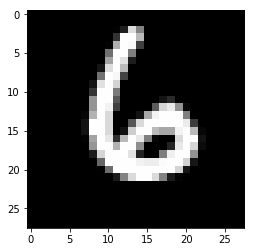

In [100]:
plt.imshow(X_train[np.random.randint(0, len(X_train)), 0, :,:])
plt.gray()
plt.show()

In [106]:
num_epochs=1
prop_valid=20
size_minibatch = 100 

print("Set network")
input_var = T.tensor4('inputs')
target_var = T.tensor4('targets')
class_var = T.ivector('classes')
seg_var = T.tensor4('segmentations')
network_cnn = build_cnn(input_var)


Set network


In [107]:
out_cnn = lasagne.layers.get_output(network_cnn)
ce_cnn = lasagne.objectives.categorical_crossentropy(out_cnn, class_var)
ace_cnn = lasagne.objectives.aggregate(ce_cnn)
params_cnn = lasagne.layers.get_all_params(network_cnn, trainable=True)
updates_cnn = lasagne.updates.nesterov_momentum(ace_cnn, params_cnn, learning_rate=0.1, momentum=0.9)
train_fn_cnn = theano.function([input_var, class_var], ace_cnn, updates=updates_cnn)

cnn = lasagne.layers.get_output(network_cnn, deterministic=True)
cnn_ce = lasagne.objectives.categorical_crossentropy(cnn, class_var)
cnn_ace = lasagne.objectives.aggregate(cnn_ce)
cnn_acc = T.mean( T.eq( T.argmax( cnn, axis=1 ), class_var ), dtype=theano.config.floatX )
eval_cnn = theano.function([input_var, class_var], [cnn_ace, cnn_acc] )

In [109]:
train_ace = 0
train_batches = 0
start_time = time.time()
for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
    inputs, classes = batch
    train_ace += train_fn_cnn( inputs, classes )
    train_batches += 1
    print(train_ace / train_batches)
test_ace = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500, shuffle=True):
    inputs, classes = batch
    ace, acc = eval_cnn( inputs, classes )
    test_ace += ace
    test_acc += acc
    test_batches += 1
print("Ace :", test_ace / test_batches)
print("ACC:\t\t{:.2f} %".format( 100*(test_acc / test_batches) ) )
#print("Acc :", test_acc / test_batches)
print("time:", time.time() - start_time , "s")

2.34345696971
2.30813666405
2.29207008295
2.27842121291
2.26266878916
2.24362617
2.21760684359
2.18191403298
2.14645467495
2.09022002258
2.03370839313
2.04559919396
2.03647417472
1.99069067553
1.93606377388
1.88084663433
1.82477809783
1.76989466611
1.71600214655
1.66382513926
1.61265259651
1.57051578448
1.53286723041
1.49232520533
1.4563657077
1.42305361498
1.39008511651
1.3565178273
1.32794316382
1.30079813286
1.27625448555
1.24842740757
1.22343366538
1.19949070325
1.17877090513
1.15840515964
1.13886097626
1.12029967769
1.10096142313
1.08144623786
1.06437914831
1.04709718644
1.03087603612
1.01588359671
1.00110240933
0.986453257938
0.97307284685
0.959055351495
0.947514844079
0.934708814317
0.92266443079
0.912057393208
0.900112637275
0.889599279889
0.879027153815
0.869142616008
0.858950651859
0.848846883624
0.837891746858
0.828076076429
0.819325136394
0.809463201816
0.800323288636
0.792017903544
0.784248055221
0.775940993056
0.769040981808
0.763118353418
0.755308457811
0.74822319131
0.7

NameError: name 'overall_time' is not defined

In [110]:
nn_cnn = lasagne.layers.get_all_param_values(network_cnn)
df_nn_cnn = pd.DataFrame(nn_cnn)
print(df_nn_cnn)

                                                   0
0  [[[[ 0.07283056  0.27840081  0.38866329  0.079...
1  [-0.382537352598, -0.0132402678698, 0.01060836...
2  [[[[-0.07562348 -0.10541602 -0.03775927  0.185...
3  [-0.0647742297855, 0.0617553937534, -0.1252164...
4  [[-0.0251504709189, -0.161661779282, 0.0178769...
5  [0.0156596528897, -0.0479010664277, -0.0839906...


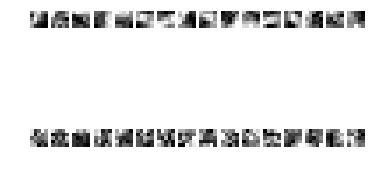

In [118]:
nbRow = 2
fig, axes = plt.subplots(nrows=nbRow, ncols=16)
l1 = df_nn_cnn[0][0]
l1 = l1.max(axis=1)
nbCol = l1.shape[0]
for c in range(nbCol):
    f = l1[c]
    axes[0, c].imshow(f)
    axes[0, c].set_axis_off()
l2 = df_nn_cnn[0][2]
l2 = l2.max(axis=1)
nbCol = l2.shape[0]
for c in range(nbCol):
    f = l2[c]
    axes[1, c].imshow(f)
    axes[1, c].set_axis_off()
#plt.gray()
plt.axis('off')
plt.show()

In [119]:
l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
# print(lasagne.layers.get_output_shape(l_in))
l_c1 = lasagne.layers.Conv2DLayer(l_in, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotNormal() )
l_c1p = lasagne.layers.MaxPool2DLayer(l_c1, pool_size=(2,2) )
l_c2 = lasagne.layers.Conv2DLayer( l_c1p, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify , W=lasagne.init.GlorotNormal() )
l_c2p = lasagne.layers.MaxPool2DLayer(l_c2, pool_size=(2,2) )
# l_cclass = lasagne.layers.FlattenLayer(l_cclass, outdim=2, )
l_out = lasagne.layers.DenseLayer(lasagne.layers.dropout(l_c2p, p=0.5), num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

lasagne.layers.set_all_param_values( l_out, lasagne.layers.get_all_param_values(network_cnn) )